# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

## Переключение версии TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета lfw.

In [2]:
ds = tfds.load(
    'lfw',    
    shuffle_files=True,
    )

In [3]:
ds

{'train': <_OptionsDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>}

In [4]:
a=ds['train'].take(20)

## Визуализация датасета lfw

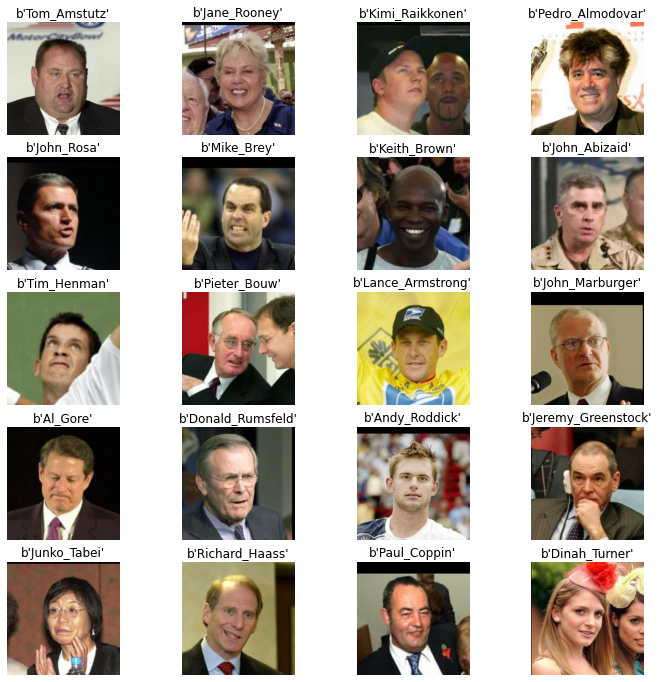

In [5]:
plt.figure(figsize=(12, 12))
for i, x in enumerate(ds['train'].take(20)):
    plt.subplot(5, 4, i+1)
    plt.title(x['label'].numpy())
    plt.imshow(x['image'])
    plt.axis('off')

In [6]:
raw_data = list(ds['train'].as_numpy_iterator())

In [7]:
IMG_SIZE = 64

def prepare_images(img):
    
    img = Image.fromarray(img)
    img = img.resize((IMG_SIZE, IMG_SIZE), resample = Image.BICUBIC)
    #img = img.convert('L')
    
    img = np.asarray(img)
    return img




X = []
for i in range(len(raw_data)):
    img = raw_data[i]['image']
    img = prepare_images(img)
    X.append(img)
    
X = np.array(X)
print('Total pic count: ', len(X))



sep = int(len(X)*0.9)
X_train = X[:sep]
X_test  = X[sep:]
print('Train len:', len(X_train), 'Test len:', len(X_test))

Total pic count:  13233
Train len: 11909 Test len: 1324


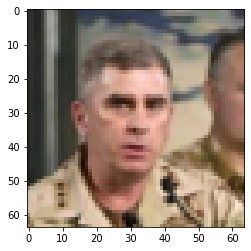

In [8]:

plt.imshow(X_train[0], cmap='gray')


In [9]:

train_x = (X_train.reshape(-1, IMG_SIZE*IMG_SIZE*3).astype(np.float32) - 127.5) / 127.5

print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

(11909, 12288) float32
-1.0 1.0


## Подготовка пайплайна данных и оптимизатора

In [10]:
INPUT_DIM = 100
NUM_EPOCHS = 50
HALF_BATCH_SIZE = 64
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0005

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def plot_muzzle(samples):
    fig = plt.figure(figsize=(16, 16))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        muzzle = (samples[j, ...].reshape(IMG_SIZE, IMG_SIZE,3)+1)/2
        ax.imshow(muzzle) #, cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

In [12]:
train_ds

<BatchDataset shapes: (64, 12288), types: tf.float32>

## Обучение GAN

## Deep Convolutional GAN (DCGAN)

In [13]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*16*16, activation='relu'),
    tf.keras.layers.Reshape((16, 16, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [14]:
try:
    generator.load_weights('generator')
    discriminator.load_weights('discriminator')
    print('weights are loaded!')
except:
    print('weights are not loaded!')    

weights are loaded!


[Step  0] D Loss: 0.6359; G Loss: 0.8970


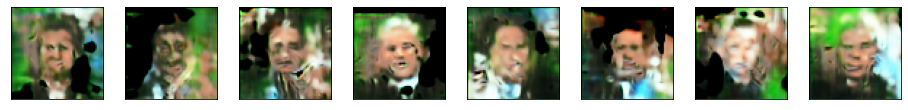

[Step 1000] D Loss: 0.6386; G Loss: 0.8349


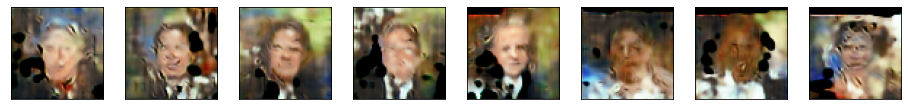

[Step 2000] D Loss: 0.6220; G Loss: 0.9961


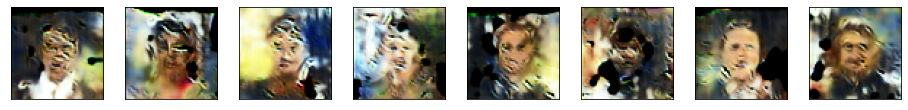

[Step 3000] D Loss: 0.6982; G Loss: 1.0031


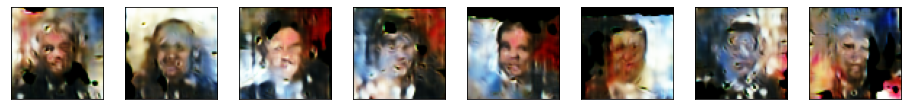

[Step 4000] D Loss: 0.5991; G Loss: 0.9962


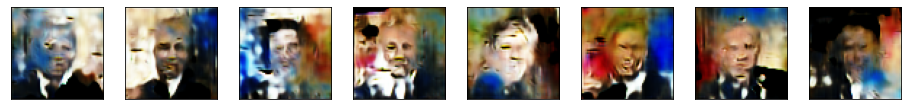

[Step 5000] D Loss: 0.6100; G Loss: 0.8819


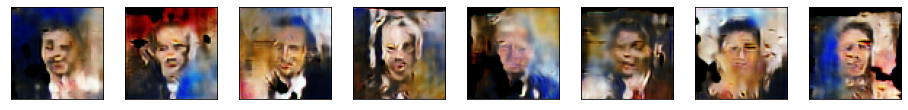

[Step 6000] D Loss: 0.6494; G Loss: 0.9717


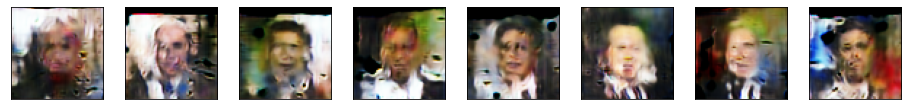

[Step 7000] D Loss: 0.6552; G Loss: 0.8910


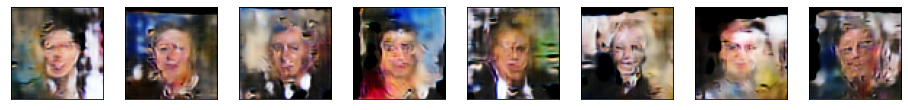

[Step 8000] D Loss: 0.6671; G Loss: 0.9563


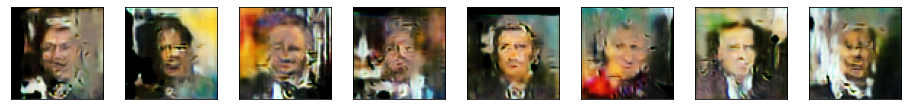

[Step 9000] D Loss: 0.6426; G Loss: 1.1225


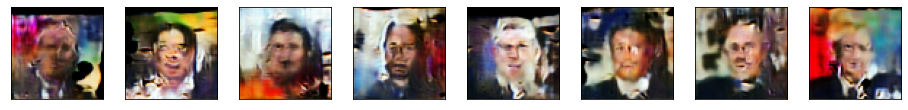

In [15]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    true_images_reshaped=np.reshape(true_images,(-1, IMG_SIZE, IMG_SIZE, 3))
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images_reshaped, 
        syntetic_images))
    #print(x_combined.shape)
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32)*0.9, 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        #print(x_combined.shape, y_combined.shape)        
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_muzzle(syntetic_images)
        generator.save_weights('generator')
        discriminator.save_weights('discriminator')


## Тестирование свёрточного генератора

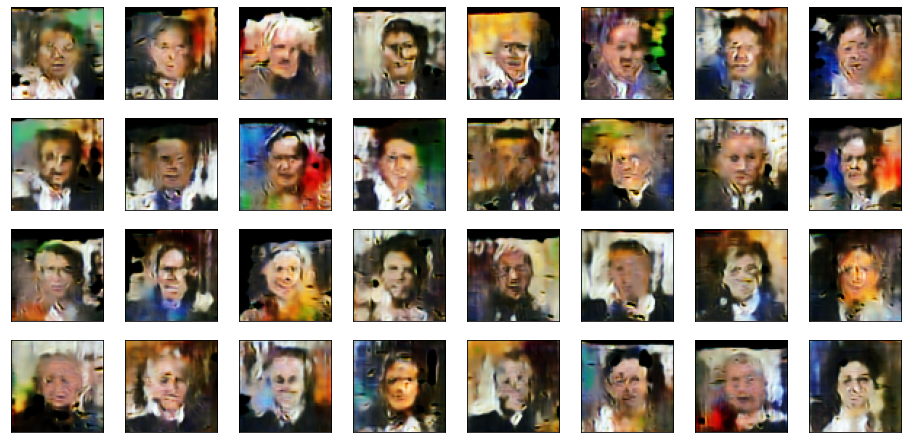

In [16]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_muzzle(syntetic_images)

## Интерполяция в латентном пространстве

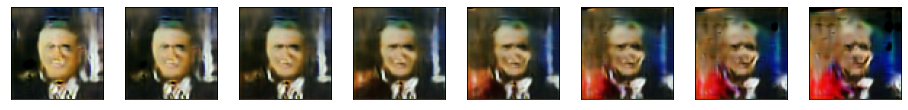

In [17]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_muzzle(syntetic_images)